# Exploratory Data Analysis

In [113]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from skimage.io import imread, imshow
from skimage import transform, img_as_float
import glob
import math

In [114]:
cwd = os.getcwd()
path = os.path.join(cwd, '..', 'src')
if not path in sys.path:
    sys.path.append(path)
#del cwd, path

In [115]:
import KaggleAmazonMain as kam

In [116]:
#Load from pickle unless something has changed
X_train = pd.read_pickle('X_train.pkl')
y_train = pd.read_pickle('y_train.pkl')
#X_train, y_train, names_train, tagged_df = kam.load_training_data(sampleOnly=True) #this creates the pickle

In [117]:
X_train.head()

,b_bimodal,b_kurtosis,b_max,b_mean,b_min,b_skew,b_std,g_bimodal,g_kurtosis,g_max,...,r_skew,r_std,sobel_colmean_std,sobel_kurtosis,sobel_max,sobel_mean,sobel_min,sobel_rowmean_std,sobel_skew,sobel_std
0,0.01,0.584727,0.462745,0.406310,0.356863,0.143465,0.010151,0.01,0.468081,0.490196,...,0.349179,0.016714,0.005138,1.217262,0.041441,0.008595,0.0,0.001003,0.924947,0.005138
1,0.06,2.618875,0.513725,0.252163,0.149020,1.108335,0.037304,0.15,-0.223049,0.603922,...,1.192432,0.070699,0.013688,11.418476,0.155384,0.016621,0.0,0.003938,2.547510,0.013688
2,0.05,-0.771360,0.388235,0.198906,0.105882,0.312114,0.031379,0.07,-0.775967,0.415686,...,0.378112,0.073480,0.009609,7.456124,0.136638,0.012053,0.0,0.002302,1.986216,0.009609
3,0.02,14.326384,0.874510,0.427071,0.313725,3.669470,0.047856,0.03,13.894092,0.882353,...,3.555662,0.090548,0.012798,53.560918,0.271884,0.006004,0.0,0.003478,6.146419,0.012798
4,0.29,-0.224812,0.952941,0.494552,0.298039,1.066036,0.175244,0.54,-0.519344,0.964706,...,0.918842,0.212183,0.014765,2.781539,0.124231,0.019790,0.0,0.003197,1.409351,0.014765


In [5]:
tagged_df.head()

NameError: name 'tagged_df' is not defined

In [9]:
#Barplot of tag counts
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 5)
print('There are {} unique tags in this data'.format(len(tagged_df.columns)))
colors = cm.rainbow(np.linspace(0, 1, len(tagged_df.columns)))
tagged_df.sum().sort_values(ascending=False).plot(title="Counts of Tags", color=colors, kind='bar')
plt.show()
tagged_df.sum().sort_values(ascending=False)

NameError: name 'tagged_df' is not defined

In [11]:
kam.plot_samples(X_train, names_train, tagged_df, nrow=4, ncol=4)

NameError: name 'names_train' is not defined

# Feature Engineering
What type of features are we working with here?
Feature engineering explores the feature data, and does feature creation.
Each image consists of pixel values in red, geen, and blue color schemes. The patterns in these pixels will  have useful trends for classifying the objects in the images and the image types. Notice how the statistical distributions of the red, green, and blue, pixels differ for different types of tags.

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(10, 6))
axes[0].imshow(X_train[1,:,:,0], cmap='Reds')
axes[1].imshow(X_train[1,:,:,1], cmap='Greens')
axes[2].imshow(X_train[1,:,:,2], cmap='Blues')

TypeError: unhashable type: 'slice'

In [8]:
plt.subplots_adjust(wspace=0, hspace=0)
for i in range(0,3):
    sample = np.random.randint(low=0, high=X_train.shape[0]-1, size = 1)
    ind = names_train[sample[0]]
    tags = kam.get_labels(ind, tagged_df)
    kam.plot_rgb_dist(X_train[sample[0],:,:,:],tags)

NameError: name 'names_train' is not defined

Create features from the raw pixel data. These metrics should be metrics that describe patterns in the trends and distributions of the pixels. 
Using binned historgram features to capture bimodality and general shape and location of distributions in red, green, and blue.

I want to try an ML algorithm with feature cdreation, and a NN with raw pixel data to compare results. 

binned mode differences is a feature created to discribe bimodal distributions. A lot of the r g b distributions are bimodal, which could offer interesting insight into the  classificatioin, so I created a feature to capture bimodal patterns in the r g b pixel distributions. The binned mode differences is simply the differnce between the two min bounds of the two largest count bins, or the two modes. If this value is large, then the two larges modes are a large distance from eachother, indicating the distribution is bimodal.

In [9]:
#Binned mode differences

def binned_mode_features_with_diagnostics(img, steps):
    ## red ##
    #split on mean
    m=img[:,:,0].flatten().mean()
    left = img[:,:,0].flatten()[img[:,:,0].flatten()<m]
    right = img[:,:,0].flatten()[img[:,:,0].flatten()>=m]
    #find mode in left and right
    max_ind_left = np.histogram(left, bins=steps, density=False)[0].argsort()[-1:]
    max_ind_right = np.histogram(right, bins=steps, density=False)[0].argsort()[-1:]
    #calc bimodal metric
    mo1 = np.histogram(right, bins=steps, density=False)[1][max_ind_right]
    mo2 = np.histogram(left, bins=steps, density=False)[1][max_ind_left]
    mods_diff_r=abs(mo1-mo2)
    print("The mean of the red distribution is {}".format(m.round(2)))
    print("After splitting on the mean, the two modes are found at {} and {}".format(mo2, mo1))
    plt.hist(img[:,:,0].flatten(), color='red', bins=steps)
    plt.axvline(img[:,:,0].mean(), color='black', linestyle='dashed', linewidth=2)
    plt.axvline(mo1, color='yellow', linestyle='dashed', linewidth=2)
    plt.axvline(mo2, color='yellow', linestyle='dashed', linewidth=2)
    plt.show()
    
    ## green ##
    m=img[:,:,1].flatten().mean()
    left = img[:,:,1].flatten()[img[:,:,1].flatten()<m]
    right = img[:,:,1].flatten()[img[:,:,1].flatten()>=m]
    max_ind_left = np.histogram(left, bins=steps, density=False)[0].argsort()[-1:]
    max_ind_right = np.histogram(right, bins=steps, density=False)[0].argsort()[-1:]
    mo1 = np.histogram(right, bins=steps, density=False)[1][max_ind_right]
    mo2 = np.histogram(left, bins=steps, density=False)[1][max_ind_left]
    mods_diff_g=abs(mo1-mo2)
    print("The mean of the green distribution is {}".format(m.round(2)))
    print("After splitting on the mean, the two modes are found at {} and {}".format(mo2, mo1))
    plt.hist(img[:,:,1].flatten(), color='green', bins=steps)
    plt.axvline(img[:,:,1].mean(), color='black', linestyle='dashed', linewidth=2)
    plt.axvline(mo1, color='yellow', linestyle='dashed', linewidth=2)
    plt.axvline(mo2, color='yellow', linestyle='dashed', linewidth=2)
    plt.show()
    
    ## blue ##
    m=img[:,:,2].flatten().mean()
    left = img[:,:,2].flatten()[img[:,:,2].flatten()<m]
    right = img[:,:,2].flatten()[img[:,:,2].flatten()>=m]
    max_ind_left = np.histogram(left, bins=steps, density=False)[0].argsort()[-1:]
    max_ind_right = np.histogram(right, bins=steps, density=False)[0].argsort()[-1:]
    mo1 = np.histogram(right, bins=steps, density=False)[1][max_ind_right]
    mo2 = np.histogram(left, bins=steps, density=False)[1][max_ind_left]
    mods_diff_b=abs(mo1-mo2)
    print("The mean of the blue distribution is {}".format(m.round(2)))
    print("After splitting on the mean, the two modes are found at {} and {}".format(mo2, mo1))
    plt.hist(img[:,:,2].flatten(), color='blue', bins=steps)
    plt.axvline(img[:,:,2].mean(), color='black', linestyle='dashed', linewidth=2)
    plt.axvline(mo1, color='yellow', linestyle='dashed', linewidth=2)
    plt.axvline(mo2, color='yellow', linestyle='dashed', linewidth=2)
    plt.show()
    
    return mods_diff_r[0].round(2), mods_diff_g[0].round(2), mods_diff_b[0].round(2)

img=X_train[2]
steps=np.arange(start=0,stop=1, step=.01)
binned_mode_features_with_diagnostics(img, steps)

KeyError: 2

Also created sobel features. blah blah blah about those

In [10]:
X_train_g = rgb2gray(X_train)

X_train_sobel = []
for i in range(X_train_g.shape[0]):
    X_train_sobel.append(filters.sobel(X_train_g[i]))
X_train_sobel = np.asarray(X_train_sobel)

NameError: name 'rgb2gray' is not defined

In [11]:
KaggleAmazonMain.plot_samples(X_train_sobel, names_train, tagged_df, 4,4)

NameError: name 'KaggleAmazonMain' is not defined

Check out the features that were made... See if they describe separation of  classes. 

Index(['b_bimodal', 'b_kurtosis', 'b_max', 'b_mean', 'b_min', 'b_skew',
       'b_std', 'g_bimodal', 'g_kurtosis', 'g_max', 'g_mean', 'g_min',
       'g_skew', 'g_std', 'r_bimodal', 'r_kurtosis', 'r_max', 'r_mean',
       'r_min', 'r_skew', 'r_std', 'sobel_colmean_std', 'sobel_kurtosis',
       'sobel_max', 'sobel_mean', 'sobel_min', 'sobel_rowmean_std',
       'sobel_skew', 'sobel_std'],
      dtype='object')


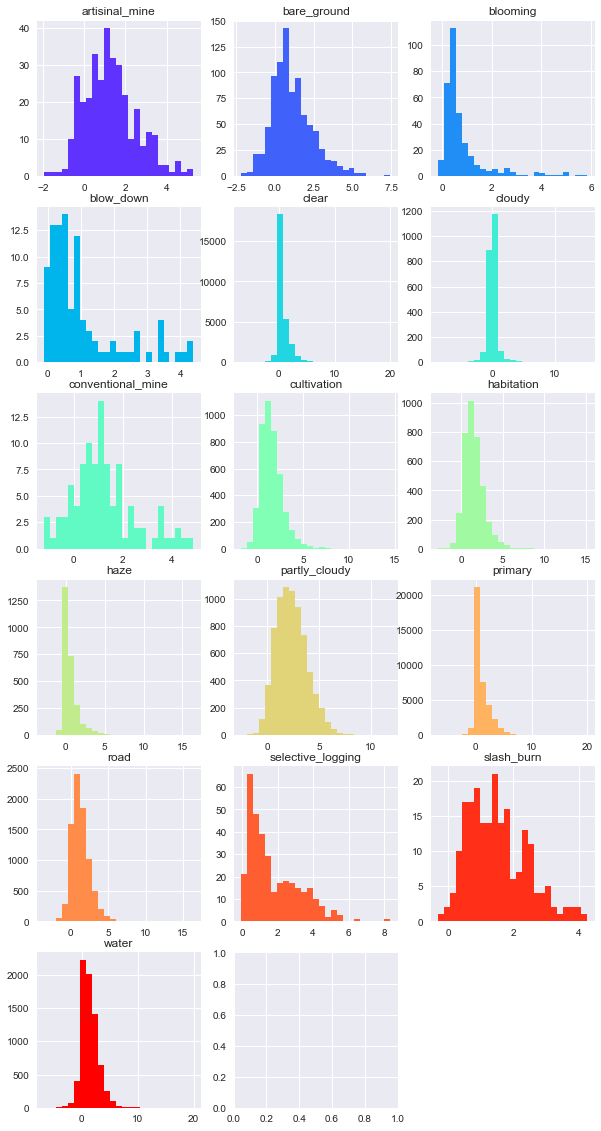

In [12]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 20)

#create table of each feature histograms for each label
X_train.set_index(y_train.index, inplace=True)
print(X_train.columns) #possible features to plot


#function to plot distributions of a featur by class label
def plot_a_feature_by_labels(feature):
    colors = cm.rainbow(np.linspace(0, 1, len(y_train.columns))) #pick colors for plots by labels
    for i in np.arange(0, len(y_train.columns)):
        col=y_train.columns[i]
        ind_list = y_train[y_train[col]==1].index.tolist()
        X_train.ix[ind_list][feature].hist(bins=25, color=colors[i])
        plt.title(col)
        plt.grid(True)
        plt.subplot(6,3,i+1) 
        
#plot_a_feature_by_labels('b_bimodal')        
plot_a_feature_by_labels('b_skew')

# Develop predictive models

In [77]:
y_train[y_train > 1] = 1
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.40, random_state=14113)

In [78]:
y_train.sum() #these are the sample sizes per class
y_validation.sum()

agriculture          1217
artisinal_mine         33
bare_ground            83
blooming               28
blow_down               7
clear                2738
cloudy                219
conventional_mine       9
cultivation           462
habitation            346
haze                  226
partly_cloudy         703
primary              3647
road                  773
selective_logging      34
slash_burn             19
water                 661
dtype: int64

In [79]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

rf = RandomForestClassifier(n_estimators = 500, 
                            max_features = 'sqrt',
                            bootstrap = True, 
                            oob_score = True,
                            n_jobs = -1,
                            random_state = 14113,
                            class_weight = 'balanced')

In [80]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=True, random_state=14113, verbose=0,
            warm_start=False)

In [81]:
#features ranking of features. 
print('The oob error for this random forest is {}'.format(rf.oob_score_.round(2)))

Feature_importance = pd.DataFrame(rf.feature_importances_, X_train.columns)
Feature_importance.columns = ['features']
Feature_importance = Feature_importance.sort_values(by='features', axis=0, ascending=False)
Feature_importance

The oob error for this random forest is 0.95


,features
r_std,0.080800
r_bimodal,0.074177
g_std,0.065895
g_bimodal,0.060136
b_bimodal,0.051778
b_std,0.041912
g_kurtosis,0.037993
r_kurtosis,0.037981
b_min,0.033944
r_mean,0.033828


## F2-score and other metrics

In [86]:
from sklearn.metrics import fbeta_score
np.asarray(y_validation)

predictions = rf.predict(X_validation)
fbeta_score(np.asarray(y_validation), predictions, beta=2, average='samples')

C:\Users\clongo\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


0.82709731513030027

precision is ... 
recall is ...
f score is ...
support is the same size of images with that label in the training data. 
blah blah blah add descriptions of these metrics 

In [87]:
#calc some other scoring metrics. precision, recall, and f1.
#The confusion matrix is diddicult to make and read for miltilabel classificatoin, but this table shows the same information 
#it shows the classes the model is perfomring well and poorly on.
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_validation, predictions)
Metrics = pd.DataFrame([precision, recall, fscore, support], index=['precision', 'recall', 'fscore', 'support'])
Metrics.columns = y_validation.columns
Metrics

C:\Users\clongo\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
precision,0.792135,1.000000,0.0,0.0,0.0,0.930183,0.868571,0.0,0.813559,0.831081,0.773006,0.915344,0.968951,0.724710,0.0,0.0,0.742138
recall,0.695152,0.090909,0.0,0.0,0.0,0.963477,0.694064,0.0,0.103896,0.355491,0.557522,0.738265,0.992597,0.565330,0.0,0.0,0.178517
fscore,0.740481,0.166667,0.0,0.0,0.0,0.946537,0.771574,0.0,0.184261,0.497976,0.647815,0.817323,0.980631,0.635174,0.0,0.0,0.287805
support,1217.000000,33.000000,83.0,28.0,7.0,2738.000000,219.000000,9.0,462.000000,346.000000,226.000000,703.000000,3647.000000,773.000000,34.0,19.0,661.000000


## Same model, different features

In [123]:
#currious to try this model on raw data with PCA.... maybe PCA will explain trends
#while looseing the location based information that is not reevent to the calssification. 
tagged_df = y_train.head()
tagged_df.reset_index(drop=True, inplace=True)

In [124]:
def load_training_data(ftype='jpg'):
    train_imgs = []
    labels = []
    im_names = []
    print('Loading {} image dataset'.format(ftype))
    path = os.path.join(cwd, '..', 'data','train-{}'.format(ftype),'*.'+ftype)
    files = glob.glob(path)
    for fs in files:
        img = imread(fs)
        # img = transform.resize(img, output_shape=(h,w,d), preserve_range=True)  if needed
        train_imgs.append(img)
        
        imname = os.path.basename(fs).split('.')[0]
        im_names.append(imname)
        
        labels_temp = tagged_df.loc[imname]
        labels.append(labels_temp)
        
        
        
    train_imgs = np.asarray(train_imgs)
    return train_imgs, labels, im_names


# In[7]:

X_train, y_train, names_train = load_training_data()



Loading jpg image dataset


KeyError: 'the label [train_0] is not in the [index]'

In [104]:
names_train

[]

In [108]:
cwd

NameError: name 'cwd' is not defined

In [ ]:
def make_raw_pixel_features():
    red = X_train[:,:,:,0].reshape(100, 256*256) # row of red pixel features for all images
    green = X_train[:,:,:,1].reshape(100, 256*256) # row of blue pixel features for all images
    blue = X_train[:,:,:,2].reshape(100, 256*256) #row of green pixel features for all images

    #Format as one dataframe with 196608 features.
    #one row of features for each image
    red = pd.DataFrame(red, index=names_train)
    red.columns = ['red_' + str(x) for x in range(0,256*256)] #create column names
    red.reset_index(inplace=True) #set index for the merge later on
    green = pd.DataFrame(green, index=names_train)
    green.columns = ['green_' + str(x) for x in range(0,256*256)]
    green.reset_index(inplace=True)
    blue = pd.DataFrame(blue, index=names_train)
    blue.columns = ['blue_' + str(x) for x in range(0,256*256)]
    blue.reset_index(inplace=True)

    #Merge into one large dataframe
    X_train_rows = pd.merge(red, green, on='index')
    X_train_rows = pd.merge(X_train_rows, blue, on='index').set_index('index')
    return X_train_rows


# In[ ]:

X_train_rows = make_raw_pixel_features()
X_train_rows.head()


In [ ]:
#Some PCA or SVD